In [22]:
#Load the data
from google.colab import files
upload = files.upload()

In [23]:
import warnings

warnings.filterwarnings('ignore')

In [24]:
!pip install joblib

In [25]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.impute import SimpleImputer
from sklearn.externals import joblib
# import seaborn as sns
# import graphvizs
# from sklearn.tree.export import export_text
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [26]:
data = 'carInsurance_train.csv'

df = pd.read_csv(data)
df.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


In [27]:
def raw_data_preprocessing(df):
  df['Communication'] = df['Communication'].fillna('none') 
  df['Outcome'] = df['Outcome'].fillna('NoPrev')

  df['Job'] = df['Job'].fillna('management')
  df['Education'] = df['Education'].fillna('secondary')

  df['CallStart'] = pd.to_datetime(df['CallStart'] )
  df['CallEnd'] = pd.to_datetime(df['CallEnd'] )
  df['CallTime'] = (df['CallEnd'] - df['CallStart']).dt.total_seconds()
  df.drop(["CallStart","CallEnd"],axis=1, inplace= True)

  feature = ['Job','Marital','Education','LastContactMonth','Outcome','Communication']
  df_onehot= pd.get_dummies(df[feature])

  df.drop(['Job','Marital','Education','LastContactMonth','Outcome','Communication'], axis=1, inplace= True)
  df= pd.concat([df_onehot, df], axis=1)
  return df

In [28]:
def train_models():
  df= pd.read_csv('carInsurance_train.csv')
  df = raw_data_preprocessing(df)

  x= df.drop(['CarInsurance','Id'],axis=1)
  y=df['CarInsurance']
  x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.3, random_state=2)
  dt= tree.DecisionTreeClassifier(criterion='entropy',max_depth=8,min_samples_split=5, random_state=20)
  dt.fit(x_train,y_train)
  joblib.dump(dt, 'decision_tree_model.joblib')

def pre_carinsurance(df1):
  dt = joblib.load('decision_tree_model.joblib')
  df2 = df1
  df1 = raw_data_preprocessing(df1)
  df1 = df1.drop(['CarInsurance','Id'],axis=1)
  pred = dt.predict(df1)
  pred = pd.DataFrame(pred, columns=["CarInsurance"])
  df2= pd.read_csv('carInsurance_test.csv')
  df2 = df2.drop(["CarInsurance"], axis=1)
  results = pd.concat([df2, pred], axis=1)
  return results

In [29]:
df= pd.read_csv('carInsurance_train.csv')
df = raw_data_preprocessing(df)

x= df.drop(['CarInsurance','Id'],axis=1)
y=df['CarInsurance']
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.3, random_state=2)
dt= tree.DecisionTreeClassifier(criterion='entropy',max_depth=8,min_samples_split=5, random_state=20)
dt.fit(x_train,y_train)
joblib.dump(dt, 'decision_tree_model.joblib')

['decision_tree_model.joblib']

In [30]:
from sklearn.metrics import accuracy_score
y_pred = dt.predict(x_test)

In [31]:
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with criterion entropy: 0.8275


In [32]:
y_pred_train = dt.predict(x_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8671


In [33]:
#Evaluate the model on the training data set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, y_pred))
print()
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print()
print('Accuracy: ', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       674
           1       0.80      0.78      0.79       468

    accuracy                           0.83      1142
   macro avg       0.82      0.82      0.82      1142
weighted avg       0.83      0.83      0.83      1142


Confusion Matrix: 
 [[581  93]
 [104 364]]

Accuracy:  0.8274956217162872


In [34]:
pip install pydotplus

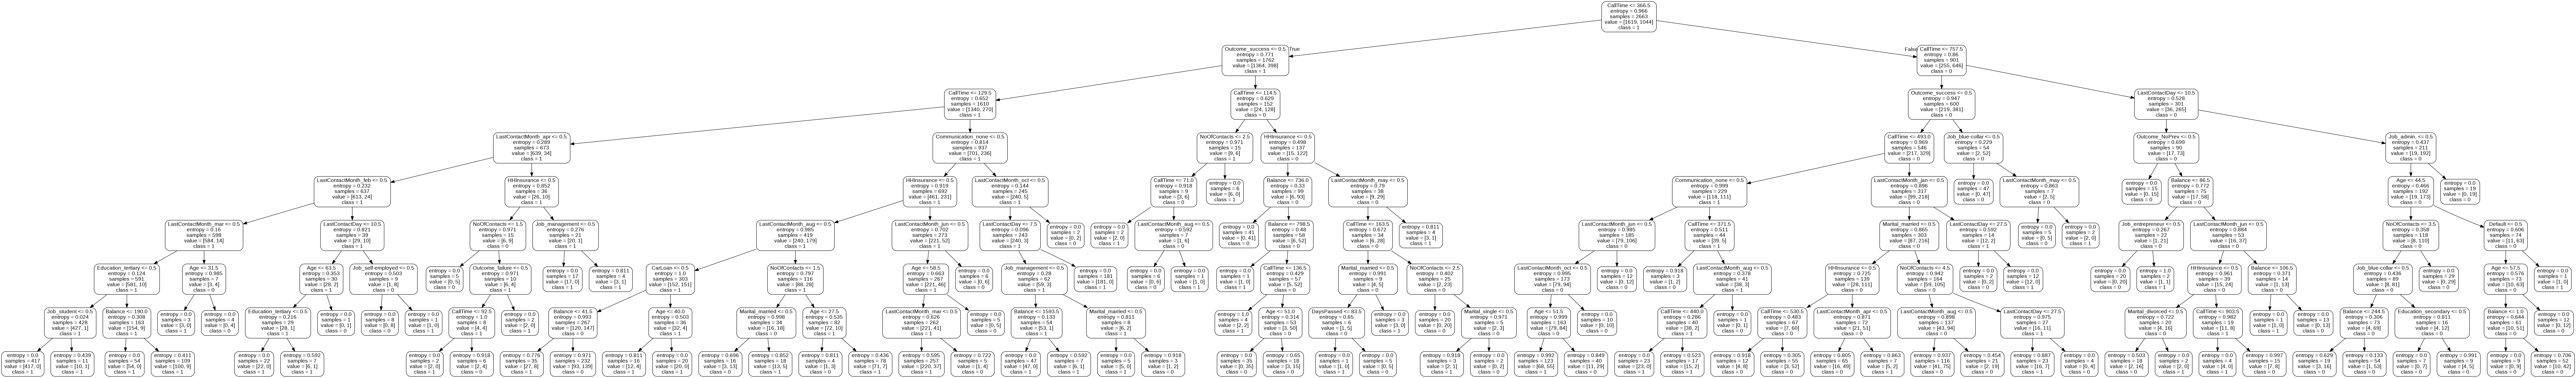

In [36]:
import pydotplus
from IPython.display import Image
dot_data = tree.export_graphviz(dt, out_file=None, 
                              feature_names= x_train.columns,  
                              class_names = ["1", "0"],  rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("graph.pdf")
Image(graph.create_png())